# Analyse de Balourd sur Souffleuse Sidel
D√©tection automatique √† partir d'un codeur 36000 points/tour

Ce notebook analyse les donn√©es d'un codeur pour d√©tecter la pr√©sence d'un balourd sur une roue en rotation.

## 1. Import des biblioth√®ques n√©cessaires

In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

## 2. Param√®tres de configuration

In [352]:
# Param√®tres du codeur et de l'analyse
POINTS_PAR_TOUR = 36000  # R√©solution du codeur

# Configuration de la machine Sidel
NOMBRE_STATIONS = 16  # Nombre de stations de soufflage (SBO20)
                      # Configurable selon la machine: 6, 8, 10, 12, 16, 20, 24, 28, 30, 34, etc.

NOMBRE_DENTS_COURONNE = 141  # Nombre de dents de la couronne d'entra√Ænement
                             # Typique: GM -> Z=151 | MM -> Z=125 | LM -> Z=xxx

# Seuils de d√©tection (√† ajuster selon votre application)
SEUIL_VARIATION_VITESSE = 0.01  # 0.5% de variation pour d√©tecter un balourd
SEUIL_AMPLITUDE_FFT = 0.01       # Amplitude minimale dans le spectre

# Sp√©cifiez le chemin vers votre fichier CSV
FICHIER_CSV = './CSV/Machines/SBO16#110755/WHEEL_ValEncoder_eng.csv'  # Modifiez ce chemin selon votre fichier


## 3. Chargement et pr√©paration des donn√©es

Rollover: Remise √† z√©ro du compteur codeur apr√®s avoir atteint sa valeur maximale (35999‚Üí0)

In [353]:
def charger_donnees_sidel(fichier_csv):
    """
    Charge les donn√©es depuis le fichier CSV au format B&R CSV English
    Le fichier contient une ligne d'en-t√™te avec m√©tadonn√©es
    puis les donn√©es temps,valeur_encodeur
    
    Param√®tres:
    -----------
    fichier_csv : str
        Chemin vers le fichier CSV contenant les donn√©es
    
    Retourne:
    ---------
    DataFrame avec les colonnes temps et position du codeur
    """
    try:
        # Lecture du fichier en ignorant la premi√®re ligne (m√©tadonn√©es)
        with open(fichier_csv, 'r') as f:
            lines = f.readlines()
        
        # Ignorer la ligne de m√©tadonn√©es
        data_lines = []
        for line in lines[1:]:
            line = line.strip()
            if line and not line.startswith('%'):
                # Enlever la virgule finale si pr√©sente
                if line.endswith(','):
                    line = line[:-1]
                data_lines.append(line)
        
        # Cr√©er le DataFrame
        data = []
        for line in data_lines:
            parts = line.split(',')
            if len(parts) >= 2:
                try:
                    time = float(parts[0])
                    encoder = float(parts[1])
                    data.append([time, encoder])
                except ValueError:
                    continue
        
        df = pd.DataFrame(data, columns=['temps', 'position_codeur'])
        
        print(f"‚úì Donn√©es charg√©es: {len(df)} points")
        print(f"  Dur√©e totale: {df['temps'].iloc[-1] - df['temps'].iloc[0]:.3f} secondes")
        print(f"  Fr√©quence d'√©chantillonnage: {1/(df['temps'].iloc[1] - df['temps'].iloc[0]):.1f} Hz")
        print(f"  Plage du codeur: {df['position_codeur'].min():.0f} - {df['position_codeur'].max():.0f}")
        
        # D√©tection et correction des sauts de codeur (rollover √† 36000)
        df = corriger_rollover(df)
        
        return df
    
    except Exception as e:
        print(f"‚ùå Erreur lors du chargement: {e}")
        return None

def corriger_rollover(df):
    """
    Corrige les sauts du codeur quand il passe de 35999 √† 0 (rollover)
    
    Rollover: Remise √† z√©ro du compteur codeur apr√®s avoir atteint sa valeur maximale (35999‚Üí0)
    """
    position = df['position_codeur'].values.copy()
    position_corrigee = np.zeros_like(position)
    position_corrigee[0] = position[0]
    
    offset = 0
    for i in range(1, len(position)):
        diff = position[i] - position[i-1]
        
        # D√©tection d'un rollover n√©gatif (35999 -> 0)
        if diff < -30000:
            offset += POINTS_PAR_TOUR
        # D√©tection d'un rollover positif (0 -> 35999)
        elif diff > 30000:
            offset -= POINTS_PAR_TOUR
        
        position_corrigee[i] = position[i] + offset
    
    df['position_corrigee'] = position_corrigee
    
    # Calcul du nombre de tours effectu√©s
    tours_effectues = (position_corrigee[-1] - position_corrigee[0]) / POINTS_PAR_TOUR
    print(f"  Tours effectu√©s: {tours_effectues:.2f}")
    
    # Visualisation de l'√©volution de la position du codeur
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Graphique 1: Position brute du codeur
    ax1.plot(df['temps'], df['position_codeur'], 'b-', linewidth=0.5)
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Position codeur brute (points)')
    ax1.set_title('Position brute du codeur (avec rollovers)')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-1000, 37000)
    
    # Ajout de lignes pour marquer les limites du codeur
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Limite basse (0)')
    ax1.axhline(y=35999, color='r', linestyle='--', alpha=0.5, label='Limite haute (35999)')
    ax1.legend(loc='upper right')
    
    # Graphique 2: Position corrig√©e (cumulative)
    ax2.plot(df['temps'], position_corrigee, 'g-', linewidth=0.5)
    ax2.set_xlabel('Temps (s)')
    ax2.set_ylabel('Position corrig√©e cumulative (points)')
    ax2.set_title(f'Position corrig√©e du codeur - {tours_effectues:.2f} tours effectu√©s')
    ax2.grid(True, alpha=0.3)
    
    # Ajout de lignes horizontales pour marquer chaque tour complet
    for i in range(int(tours_effectues) + 1):
        y_tour = position_corrigee[0] + i * POINTS_PAR_TOUR
        ax2.axhline(y=y_tour, color='orange', linestyle=':', alpha=0.5)
        if i <= 5:  # Limiter l'annotation aux 5 premiers tours pour la lisibilit√©
            ax2.text(df['temps'].iloc[-1] * 0.98, y_tour, f'Tour {i}', 
                    verticalalignment='bottom', fontsize=8)
    
    # Calcul et affichage de la vitesse de rotation moyenne
    vitesse_rotation_moyenne = tours_effectues / (df['temps'].iloc[-1] - df['temps'].iloc[0])
    duree_moyenne_tour = (df['temps'].iloc[-1] - df['temps'].iloc[0]) / tours_effectues if tours_effectues > 0 else 0
    
    ax2.text(0.02, 0.98, f'Vitesse moyenne: {vitesse_rotation_moyenne:.2f} tours/s ({vitesse_rotation_moyenne*60:.1f} RPM)\nDur√©e moyenne par tour: {duree_moyenne_tour:.2f} s',
            transform=ax2.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"  Vitesse de rotation moyenne: {vitesse_rotation_moyenne:.2f} tours/s ({vitesse_rotation_moyenne*60:.1f} RPM)")
    print(f"  Dur√©e moyenne par tour: {duree_moyenne_tour:.2f} secondes")
    
    return df

## 4. Chargement des donn√©es r√©elles

‚úì Donn√©es charg√©es: 32767 points
  Dur√©e totale: 39.319 secondes
  Fr√©quence d'√©chantillonnage: 837.5 Hz
  Plage du codeur: 0 - 35999
  Tours effectu√©s: 14.37


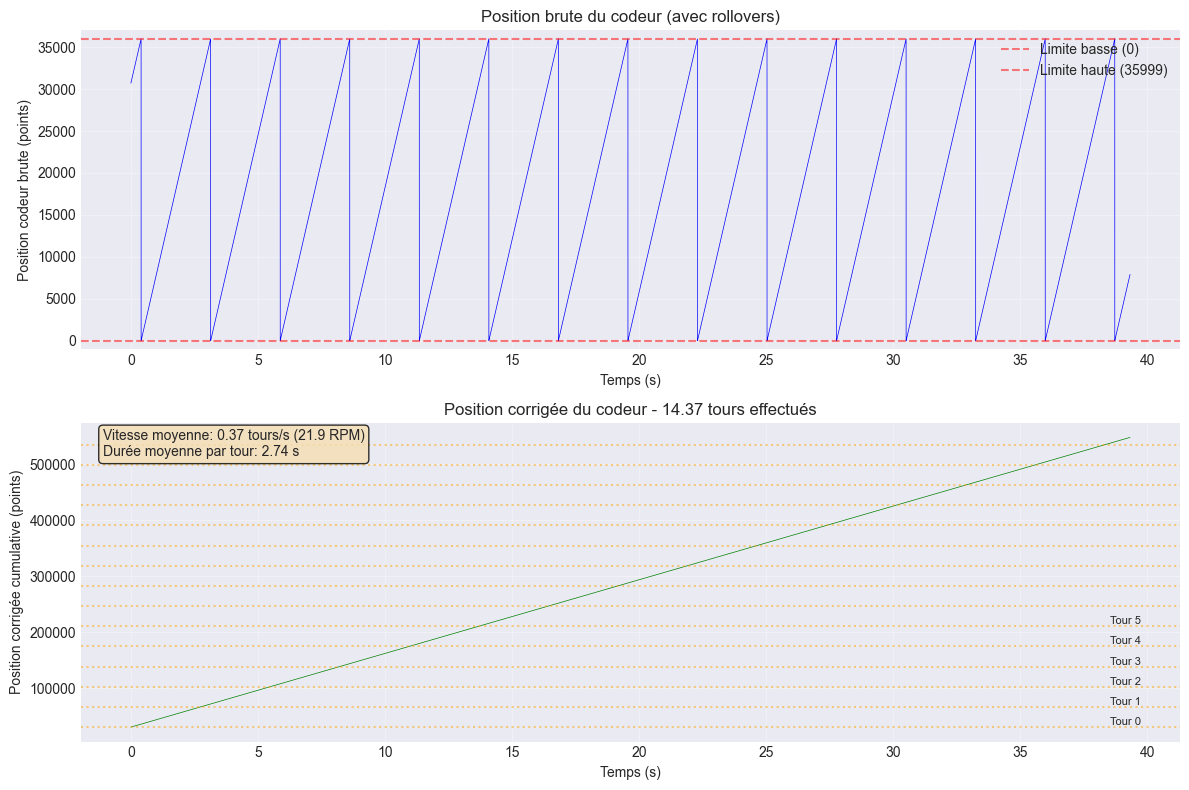

  Vitesse de rotation moyenne: 0.37 tours/s (21.9 RPM)
  Dur√©e moyenne par tour: 2.74 secondes


In [354]:
# Chargement du fichier CSV
df = charger_donnees_sidel(FICHIER_CSV)

if df is None:
    print("\n" + "="*60)
    print("‚ùå ERREUR: Impossible de charger le fichier")
    print("="*60)
    print(f"V√©rifiez que le fichier '{FICHIER_CSV}' existe dans le bon r√©pertoire.")
    print("Si votre fichier a un nom diff√©rent, modifiez la variable FICHIER_CSV.")
    print("\nExemples de chemins valides:")
    print("  ‚Ä¢ 'WHEEL_ValEncoder_eng.csv' (m√™me dossier que le notebook)")
    print("  ‚Ä¢ './data/WHEEL_ValEncoder_eng.csv' (sous-dossier 'data')")
    print("  ‚Ä¢ '../WHEEL_ValEncoder_eng.csv' (dossier parent)")
    raise FileNotFoundError(f"Le fichier '{FICHIER_CSV}' n'a pas √©t√© trouv√©. Arr√™t de l'analyse.")

## 5. Calcul de la vitesse instantan√©e et analyse

Le filtre Butterworth lisse le signal en supprimant les vibrations parasites tout en conservant les variations importantes li√©es au balourd
Ce filtre agit comme un 'lisseur' qui garde les variations lentes (balourd) et supprime les variations rapides (bruit de mesure, vibrations m√©caniques)

  ‚ö†Ô∏è Correction des artefacts de bord : 32 points aux extr√©mit√©s

‚úì Vitesse instantan√©e calcul√©e
  Vitesse moyenne: 13159.4 points/seconde
  Variation max: 1.319%
  √âcart-type des variations: 0.242%


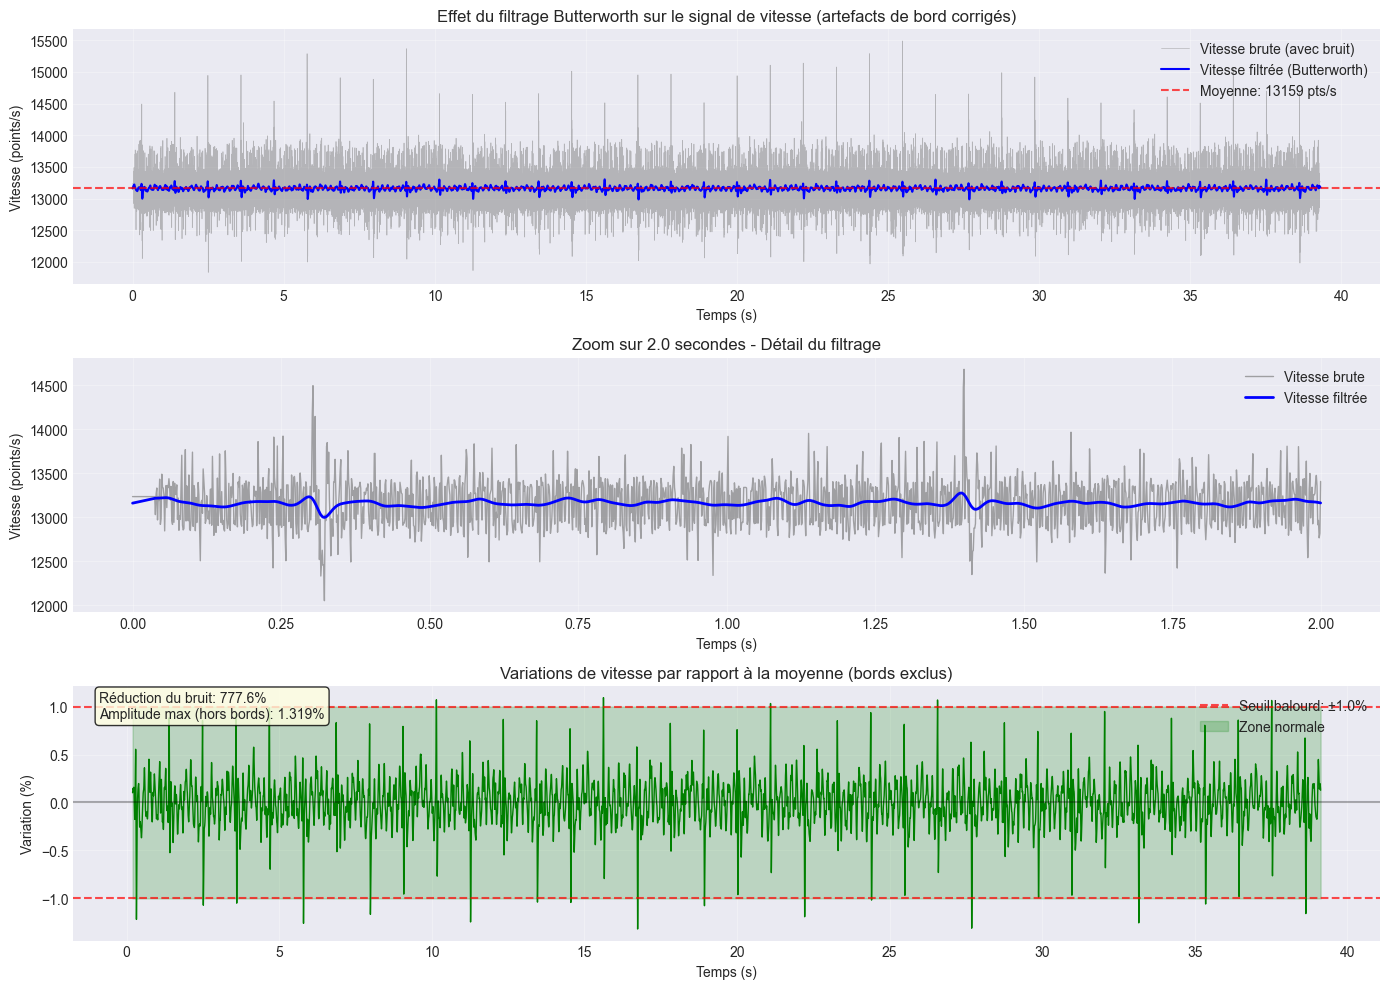

In [355]:
def calculer_vitesse_instantanee(df):
    """
    Calcule la vitesse instantan√©e √† partir de la position du codeur
    """
    # Utiliser la position corrig√©e pour √©viter les discontinuit√©s
    position = df['position_corrigee'].values
    temps = df['temps'].values
    
    # Calcul de la vitesse instantan√©e (d√©riv√©e de la position)
    vitesse_brute = np.gradient(position, temps)
    
    # CORRECTION DES ARTEFACTS DE BORD
    # On exclut les premiers et derniers points (typiquement 0.5% des donn√©es)
    n_points_exclus = max(10, int(len(vitesse_brute) * 0.001))  # 0.1% ou minimum 10 points
    
    # Remplacement des valeurs aux extr√©mit√©s par la m√©diane locale
    vitesse_brute[:n_points_exclus] = np.median(vitesse_brute[n_points_exclus:n_points_exclus*3])
    vitesse_brute[-n_points_exclus:] = np.median(vitesse_brute[-n_points_exclus*3:-n_points_exclus])
    
    # Filtrage passe-bas pour √©liminer le bruit haute fr√©quence
    # Le filtre Butterworth lisse le signal en supprimant les vibrations parasites
    # tout en conservant les variations importantes li√©es au balourd
    freq_echantillonnage = 1 / (temps[1] - temps[0])
    freq_coupure = 20  # Hz - fr√©quence au-del√† de laquelle on consid√®re que c'est du bruit
    
    # Conception du filtre Butterworth d'ordre 3
    # Ce filtre agit comme un "lisseur" qui garde les variations lentes (balourd)
    # et supprime les variations rapides (bruit de mesure, vibrations m√©caniques)
    b, a = signal.butter(3, freq_coupure / (freq_echantillonnage / 2), 'low')
    
    # Application du filtre
    vitesse_filtree = signal.filtfilt(b, a, vitesse_brute)
    
    # DEUXI√àME CORRECTION : Forcer les extr√©mit√©s √† la moyenne locale
    vitesse_moyenne_debut = np.mean(vitesse_filtree[n_points_exclus:n_points_exclus*5])
    vitesse_moyenne_fin = np.mean(vitesse_filtree[-n_points_exclus*5:-n_points_exclus])
    
    # Lissage progressif aux extr√©mit√©s
    for i in range(n_points_exclus):
        # D√©but : transition progressive vers la moyenne locale
        factor = i / n_points_exclus
        vitesse_filtree[i] = vitesse_moyenne_debut * (1 - factor) + vitesse_filtree[n_points_exclus] * factor
        
        # Fin : transition progressive depuis la moyenne locale
        vitesse_filtree[-(i+1)] = vitesse_moyenne_fin * (1 - factor) + vitesse_filtree[-(n_points_exclus+1)] * factor
    
    print(f"  ‚ö†Ô∏è Correction des artefacts de bord : {n_points_exclus} points aux extr√©mit√©s")
    
    # Ajout au DataFrame
    df['vitesse_brute'] = vitesse_brute
    df['vitesse_filtree'] = vitesse_filtree
    
    # Calcul de la vitesse moyenne et des variations
    vitesse_moyenne = vitesse_filtree.mean()
    df['variation_vitesse'] = (vitesse_filtree - vitesse_moyenne) / vitesse_moyenne
    
    print(f"\n‚úì Vitesse instantan√©e calcul√©e")
    print(f"  Vitesse moyenne: {vitesse_moyenne:.1f} points/seconde")
    print(f"  Variation max: {df['variation_vitesse'].abs().max()*100:.3f}%")
    print(f"  √âcart-type des variations: {df['variation_vitesse'].std()*100:.3f}%")
    
    # Visualisation de l'effet du filtrage
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
    
    # Graphique 1: Comparaison vitesse brute vs filtr√©e (vue compl√®te)
    ax1.plot(df['temps'], vitesse_brute, 'gray', alpha=0.5, linewidth=0.5, label='Vitesse brute (avec bruit)')
    ax1.plot(df['temps'], vitesse_filtree, 'b-', linewidth=1.5, label='Vitesse filtr√©e (Butterworth)')
    ax1.axhline(y=vitesse_moyenne, color='r', linestyle='--', alpha=0.7, 
                label=f'Moyenne: {vitesse_moyenne:.0f} pts/s')
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Vitesse (points/s)')
    ax1.set_title('Effet du filtrage Butterworth sur le signal de vitesse (artefacts de bord corrig√©s)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2: Zoom sur 2 secondes pour voir le d√©tail
    temps_zoom = 2.0  # Zoom sur les 2 premi√®res secondes
    mask_zoom = df['temps'] <= temps_zoom
    ax2.plot(df['temps'][mask_zoom], vitesse_brute[mask_zoom], 'gray', alpha=0.7, 
             linewidth=1, label='Vitesse brute')
    ax2.plot(df['temps'][mask_zoom], vitesse_filtree[mask_zoom], 'b-', 
             linewidth=2, label='Vitesse filtr√©e')
    ax2.set_xlabel('Temps (s)')
    ax2.set_ylabel('Vitesse (points/s)')
    ax2.set_title(f'Zoom sur {temps_zoom} secondes - D√©tail du filtrage')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Graphique 3: Variations en pourcentage (signal filtr√©)
    # On exclut les zones de bord pour une meilleure visualisation
    n_exclus = max(10, int(len(df) * 0.005))
    temps_clean = df['temps'].iloc[n_exclus:-n_exclus]
    variation_clean = df['variation_vitesse'].iloc[n_exclus:-n_exclus]
    
    ax3.plot(temps_clean, variation_clean*100, 'g-', linewidth=1)
    ax3.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax3.axhline(y=SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--', alpha=0.7, 
                label=f'Seuil balourd: ¬±{SEUIL_VARIATION_VITESSE*100:.1f}%')
    ax3.axhline(y=-SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--', alpha=0.7)
    ax3.fill_between(temps_clean, -SEUIL_VARIATION_VITESSE*100, SEUIL_VARIATION_VITESSE*100, 
                     alpha=0.2, color='green', label='Zone normale')
    ax3.set_xlabel('Temps (s)')
    ax3.set_ylabel('Variation (%)')
    ax3.set_title('Variations de vitesse par rapport √† la moyenne (bords exclus)')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    # Ajout d'informations statistiques
    ax3.text(0.02, 0.98, 
            f'R√©duction du bruit: {(vitesse_brute[n_exclus:-n_exclus].std()/vitesse_filtree[n_exclus:-n_exclus].std() - 1)*100:.1f}%\n' +
            f'Amplitude max (hors bords): {variation_clean.abs().max()*100:.3f}%',
            transform=ax3.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return df

df = calculer_vitesse_instantanee(df)

## 6. Analyse fr√©quentielle (FFT)
La FFT (Fast Fourier Transform) d√©compose notre signal en ses diff√©rentes fr√©quences de vibration.
Un balourd cr√©e une vibration p√©riodique √† la fr√©quence de rotation de la roue.
Si on d√©tecte un pic dominant √† cette fr√©quence, c'est un signe fort de balourd.

En termes simples :

La FFT est comme un "analyseur de sons" qui identifie toutes les fr√©quences pr√©sentes dans le signal
Un balourd fait vibrer la roue 1 fois par tour (comme une machine √† laver d√©s√©quilibr√©e)
Si on trouve cette fr√©quence caract√©ristique dans l'analyse, on a probablement un balourd


‚úì Analyse FFT effectu√©e
  Fr√©quence de rotation calcul√©e: 0.365 Hz (21.9 RPM)
  Fr√©quence d'engr√®nement couronne (141 dents): 51.5 Hz
  Nombre de pics significatifs: 0

  Cr√©ation des graphiques FFT...
  Fr√©quence de rotation pour les marqueurs: 0.365 Hz
  Ajout des marqueurs de tours (freq=0.365 Hz)...
  Marquage de 14 tours (p√©riode=2.74s)


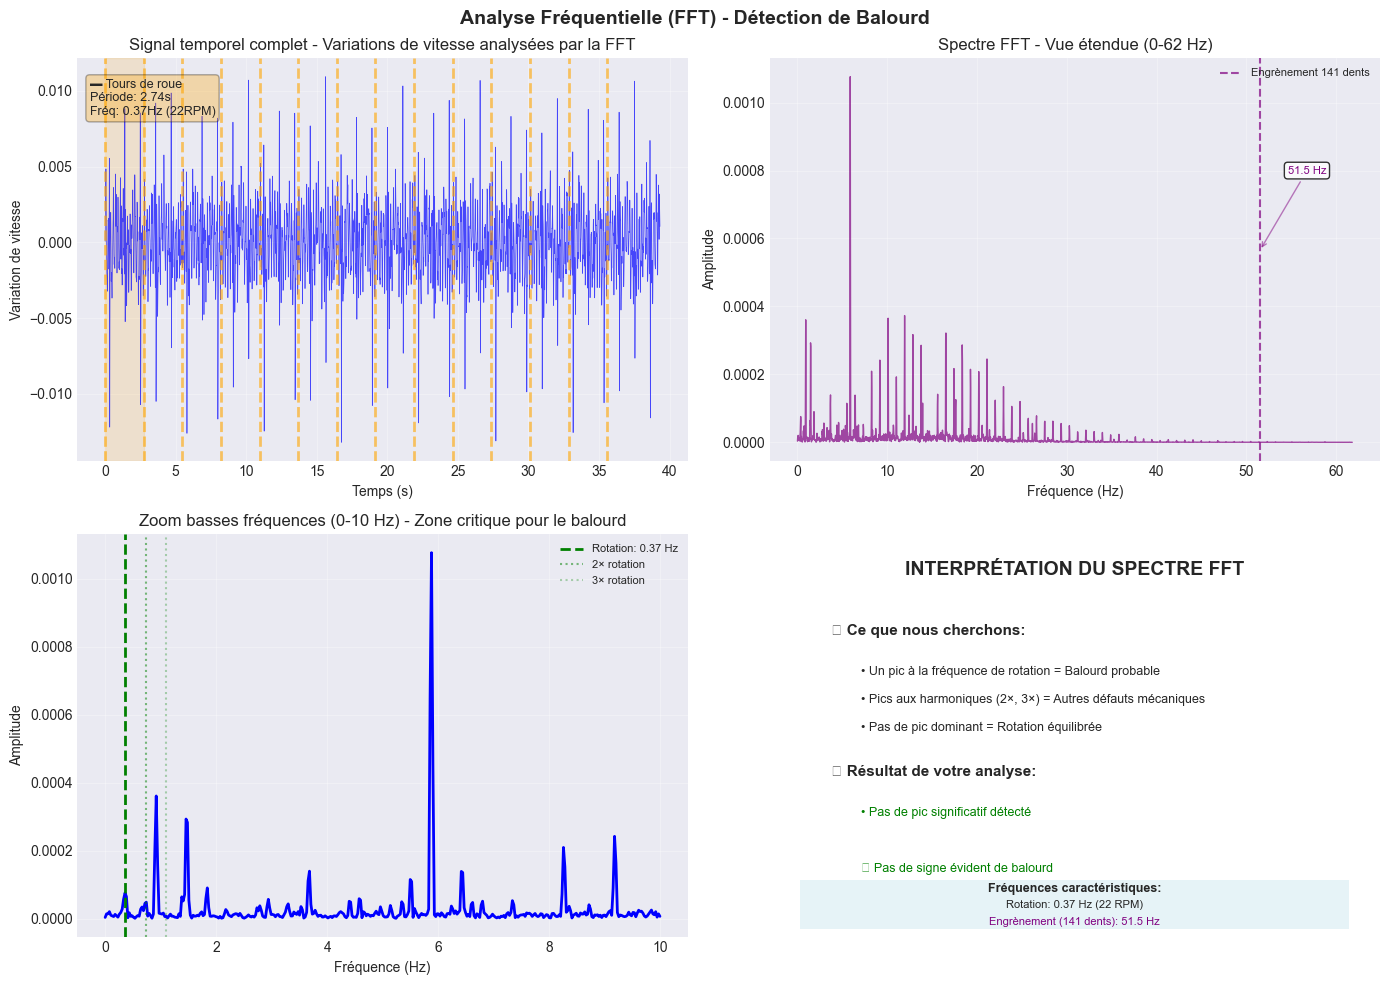


üìñ GUIDE DE LECTURE DES GRAPHIQUES FFT

üéØ COMMENT INTERPR√âTER CES GRAPHIQUES :

1Ô∏è‚É£ SIGNAL TEMPOREL (en haut √† gauche)
   ‚Ä¢ Montre les variations de vitesse dans le temps
   ‚Ä¢ Lignes orange = Marqueurs de tours complets
   ‚Ä¢ Si r√©gulier = rotation stable

2Ô∏è‚É£ SPECTRE FFT COMPLET (en haut √† droite)
   ‚Ä¢ Panorama de toutes les vibrations d√©tect√©es
   ‚Ä¢ Plus le pic est haut = plus la vibration est forte

3Ô∏è‚É£ ZOOM BASSES FR√âQUENCES (en bas √† gauche) ‚≠ê LE PLUS IMPORTANT
   ‚Ä¢ Zone critique pour d√©tecter le balourd
   ‚Ä¢ üü¢ Ligne verte continue = Fr√©quence de rotation de votre roue
   ‚Ä¢ üî¥ Points rouges = Pics de vibration d√©tect√©s
   ‚Ä¢ Si un point rouge est sur la ligne verte = BALOURD !

üìä DIAGNOSTIC RAPIDE :
   ‚úÖ PAS DE BALOURD si : Pas de pic rouge sur la ligne verte
   ‚ö†Ô∏è BALOURD D√âTECT√â si : Gros pic rouge sur ou pr√®s de la ligne verte
   üîß AUTRES PROBL√àMES si : Pics sur les lignes pointill√©es (2√ó, 3√ó rotation)

üí

In [356]:
def analyse_fft_complete(df):
    """
    Effectue une analyse FFT d√©taill√©e pour identifier les fr√©quences dominantes
    """
    # Signal √† analyser (variations de vitesse)
    signal_vitesse = df['variation_vitesse'].values
    temps = df['temps'].values
    
    # Param√®tres FFT
    N = len(signal_vitesse)
    dt = temps[1] - temps[0]
    
    # Application d'une fen√™tre de Hanning pour r√©duire les effets de bord
    window = np.hanning(N)
    signal_windowed = signal_vitesse * window
    
    # FFT
    yf = fft(signal_windowed)
    xf = fftfreq(N, dt)[:N//2]
    amplitudes = 2.0/N * np.abs(yf[:N//2])
    
    # Recherche des pics principaux
    peaks, properties = find_peaks(amplitudes[1:], height=SEUIL_AMPLITUDE_FFT)
    peaks = peaks + 1  # Correction de l'indice (on avait ignor√© le DC)
    
    # Calcul de la fr√©quence de rotation estim√©e EN PREMIER
    duree_totale = temps[-1] - temps[0]
    tours_effectues = (df['position_corrigee'].iloc[-1] - df['position_corrigee'].iloc[0]) / POINTS_PAR_TOUR
    freq_rotation_estimee = tours_effectues / duree_totale if duree_totale > 0 else 0
    
    # Calcul de la fr√©quence d'engr√®nement de la couronne
    freq_engrenement = freq_rotation_estimee * NOMBRE_DENTS_COURONNE
    
    print(f"\n‚úì Analyse FFT effectu√©e")
    print(f"  Fr√©quence de rotation calcul√©e: {freq_rotation_estimee:.3f} Hz ({freq_rotation_estimee*60:.1f} RPM)")
    print(f"  Fr√©quence d'engr√®nement couronne ({NOMBRE_DENTS_COURONNE} dents): {freq_engrenement:.1f} Hz")
    print(f"  Nombre de pics significatifs: {len(peaks)}")
    
    if len(peaks) > 0:
        # Tri des pics par amplitude
        sorted_peaks = sorted(peaks, key=lambda x: amplitudes[x], reverse=True)
        
        print("\n  Fr√©quences principales d√©tect√©es:")
        for i, peak_idx in enumerate(sorted_peaks[:5]):  # Top 5 fr√©quences
            freq = xf[peak_idx]
            amp = amplitudes[peak_idx]
            print(f"    {i+1}. {freq:.3f} Hz (amplitude: {amp:.4f})")
        
        # V√©rification si une fr√©quence correspond √† la rotation
        freq_dominante = xf[sorted_peaks[0]]
        ratio = freq_dominante / freq_rotation_estimee if freq_rotation_estimee > 0 else 0
        
        if 0.8 < ratio < 1.2:
            print(f"  ‚ö†Ô∏è Fr√©quence dominante proche de 1√ó rotation (ratio: {ratio:.2f})")
            balourd_probable = True
        else:
            balourd_probable = False
    else:
        sorted_peaks = []
        freq_dominante = 0
        balourd_probable = False
    
    # === VISUALISATION DES R√âSULTATS FFT ===
    print(f"\n  Cr√©ation des graphiques FFT...")
    print(f"  Fr√©quence de rotation pour les marqueurs: {freq_rotation_estimee:.3f} Hz")
    
    # Visualisation des r√©sultats FFT
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Graphique 1: Signal temporel analys√© (toute la dur√©e)
    ax1.plot(temps, signal_vitesse, 'b-', linewidth=0.5, alpha=0.7)
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Variation de vitesse')
    ax1.set_title('Signal temporel complet - Variations de vitesse analys√©es par la FFT')
    ax1.grid(True, alpha=0.3)
    
    # Marquer les p√©riodes de rotation
    print(f"  Ajout des marqueurs de tours (freq={freq_rotation_estimee:.3f} Hz)...")
    if freq_rotation_estimee > 0:
        periode_rotation = 1 / freq_rotation_estimee
        nb_tours_a_marquer = min(20, int(temps[-1] / periode_rotation))
        print(f"  Marquage de {nb_tours_a_marquer} tours (p√©riode={periode_rotation:.2f}s)")
        
        for i in range(nb_tours_a_marquer):
            t_tour = i * periode_rotation
            if t_tour <= temps[-1]:
                ax1.axvline(x=t_tour, color='orange', linestyle='--', alpha=0.6, linewidth=2)
        
        # Ajouter une bande color√©e pour le premier tour
        if periode_rotation <= temps[-1]:
            ax1.axvspan(0, periode_rotation, alpha=0.15, color='orange')
        
        # Ajouter la l√©gende
        ax1.text(0.02, 0.95, 
                f'‚ñ¨ Tours de roue\nP√©riode: {periode_rotation:.2f}s\nFr√©q: {freq_rotation_estimee:.2f}Hz ({freq_rotation_estimee*60:.0f}RPM)', 
                transform=ax1.transAxes, verticalalignment='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
    else:
        print("  ‚ö†Ô∏è Pas de marqueurs de tours (fr√©quence de rotation = 0)")
    
    # Graphique 2: Spectre FFT complet avec zone √©tendue pour voir l'engr√®nement
    # D√©terminer la plage d'affichage selon la fr√©quence d'engr√®nement
    max_freq_affichage = min(max(freq_engrenement * 1.2, 50), len(xf)//4)
    mask_display = xf < max_freq_affichage
    
    ax2.plot(xf[mask_display], amplitudes[mask_display], 'purple', linewidth=1, alpha=0.7)
    
    # Marquer la fr√©quence d'engr√®nement si elle est dans la plage
    if freq_engrenement > 0 and freq_engrenement < max_freq_affichage:
        ax2.axvline(x=freq_engrenement, color='purple', linestyle='--', 
                   linewidth=1.5, alpha=0.7, label=f'Engr√®nement {NOMBRE_DENTS_COURONNE} dents')
        # Ajouter une annotation d√©cal√©e pour √©viter la superposition
        y_max = ax2.get_ylim()[1]
        ax2.annotate(f'{freq_engrenement:.1f} Hz', 
                    xy=(freq_engrenement, y_max * 0.5),
                    xytext=(freq_engrenement + max_freq_affichage * 0.05, y_max * 0.7),
                    arrowprops=dict(arrowstyle='->', color='purple', alpha=0.5),
                    fontsize=8, color='purple',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax2.set_xlabel('Fr√©quence (Hz)')
    ax2.set_ylabel('Amplitude')
    ax2.set_title(f'Spectre FFT - Vue √©tendue (0-{max_freq_affichage:.0f} Hz)')
    if freq_engrenement > 0 and freq_engrenement < max_freq_affichage:
        ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # Graphique 3: Zoom sur les basses fr√©quences (0-10 Hz)
    mask_zoom = xf < 10
    ax3.plot(xf[mask_zoom], amplitudes[mask_zoom], 'b-', linewidth=2)
    
    # Marquer les pics d√©tect√©s
    peaks_zoom = peaks[peaks < np.sum(mask_zoom)]
    if len(peaks_zoom) > 0:
        ax3.plot(xf[peaks_zoom], amplitudes[peaks_zoom], 'ro', markersize=10, label='Pics d√©tect√©s')
        
        # Annoter les 3 premiers pics
        for i, peak in enumerate(peaks_zoom[:3]):
            ax3.annotate(f'{xf[peak]:.2f} Hz', 
                        xy=(xf[peak], amplitudes[peak]),
                        xytext=(10, 10 + i*15), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                        fontsize=9)
    
    # Marquer la fr√©quence de rotation th√©orique
    if freq_rotation_estimee > 0:
        ax3.axvline(x=freq_rotation_estimee, color='green', linestyle='--', 
                   linewidth=2, label=f'Rotation: {freq_rotation_estimee:.2f} Hz')
        # Marquer les harmoniques de rotation (2√ó, 3√ó)
        ax3.axvline(x=freq_rotation_estimee*2, color='green', linestyle=':', 
                   alpha=0.5, label=f'2√ó rotation')
        ax3.axvline(x=freq_rotation_estimee*3, color='green', linestyle=':', 
                   alpha=0.3, label=f'3√ó rotation')
    
    # Marquer la fr√©quence d'engr√®nement de la couronne (si visible dans la plage)
    if freq_engrenement > 0 and freq_engrenement < 10:
        ax3.axvline(x=freq_engrenement, color='purple', linestyle='--', 
                   linewidth=2, label=f'Engr√®nement: {freq_engrenement:.1f} Hz')
        # Identifier si un pic correspond √† l'engr√®nement
        for peak in peaks_zoom:
            if abs(xf[peak] - freq_engrenement) < 0.5:  # Tol√©rance de 0.5 Hz
                ax3.annotate(f'Jeu denture?', 
                           xy=(xf[peak], amplitudes[peak]),
                           xytext=(-30, 20), textcoords='offset points',
                           arrowprops=dict(arrowstyle='->', color='purple', alpha=0.7),
                           fontsize=9, color='purple', fontweight='bold')
    
    ax3.set_xlabel('Fr√©quence (Hz)')
    ax3.set_ylabel('Amplitude')
    ax3.set_title('Zoom basses fr√©quences (0-10 Hz) - Zone critique pour le balourd')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # Graphique 4: Interpr√©tation visuelle
    ax4.axis('off')
    
    # Cr√©er une repr√©sentation sch√©matique avec espacement vertical appropri√©
    y_pos = 0.90
    ax4.text(0.5, y_pos, 'INTERPR√âTATION DU SPECTRE FFT', 
            fontsize=14, fontweight='bold', ha='center')
    
    y_pos = 0.75
    ax4.text(0.1, y_pos, 'üìä Ce que nous cherchons:', fontsize=11, fontweight='bold')
    
    y_pos = 0.65
    ax4.text(0.15, y_pos, '‚Ä¢ Un pic √† la fr√©quence de rotation = Balourd probable', fontsize=9)
    y_pos = 0.58
    ax4.text(0.15, y_pos, '‚Ä¢ Pics aux harmoniques (2√ó, 3√ó) = Autres d√©fauts m√©caniques', fontsize=9)
    y_pos = 0.51
    ax4.text(0.15, y_pos, '‚Ä¢ Pas de pic dominant = Rotation √©quilibr√©e', fontsize=9)
    
    y_pos = 0.40
    ax4.text(0.1, y_pos, 'üîç R√©sultat de votre analyse:', fontsize=11, fontweight='bold')
    
    y_pos = 0.30
    pic_engrenement = False  # Initialiser la variable
    
    if balourd_probable:
        ax4.text(0.15, y_pos, f'‚úì Pic d√©tect√© √† {freq_dominante:.2f} Hz', fontsize=9, color='red')
        y_pos = 0.23
        ax4.text(0.15, y_pos, f'‚úì Correspond √† la rotation ({freq_rotation_estimee:.2f} Hz)', 
                fontsize=9, color='red')
        y_pos = 0.16
        ax4.text(0.15, y_pos, '‚ö†Ô∏è BALOURD PROBABLE', fontsize=10, color='red', fontweight='bold')
    else:
        if len(peaks) > 0:
            ax4.text(0.15, y_pos, f'‚Ä¢ Pics d√©tect√©s mais pas √† la fr√©quence de rotation', 
                    fontsize=9, color='orange')
            # V√©rifier si un pic correspond √† l'engr√®nement
            for peak in peaks:
                if abs(xf[peak] - freq_engrenement) < 1.0:  # Tol√©rance de 1 Hz
                    pic_engrenement = True
                    y_pos = 0.23
                    ax4.text(0.15, y_pos, f'‚Ä¢ Pic √† {xf[peak]:.1f} Hz ‚âà Engr√®nement', 
                            fontsize=9, color='purple')
                    y_pos = 0.16
                    ax4.text(0.15, y_pos, '‚Üí Possible jeu dans la denture', 
                            fontsize=9, color='purple', style='italic')
                    break
        else:
            ax4.text(0.15, y_pos, '‚Ä¢ Pas de pic significatif d√©tect√©', fontsize=9, color='green')
        
        if not pic_engrenement:
            y_pos = 0.16
            ax4.text(0.15, y_pos, '‚úì Pas de signe √©vident de balourd', fontsize=9, color='green')
    
    # Ajouter une l√©gende visuelle avec info couronne (position fixe en bas)
    y_box = 0.02
    ax4.add_patch(plt.Rectangle((0.05, y_box), 0.9, 0.12, 
                               fill=True, facecolor='lightblue', alpha=0.3))
    ax4.text(0.5, y_box + 0.09, 'Fr√©quences caract√©ristiques:', 
            fontsize=9, ha='center', fontweight='bold')
    ax4.text(0.5, y_box + 0.05, f'Rotation: {freq_rotation_estimee:.2f} Hz ({freq_rotation_estimee*60:.0f} RPM)', 
            fontsize=8, ha='center')
    ax4.text(0.5, y_box + 0.01, f'Engr√®nement ({NOMBRE_DENTS_COURONNE} dents): {freq_engrenement:.1f} Hz', 
            fontsize=8, ha='center', color='purple')
    
    plt.suptitle('Analyse Fr√©quentielle (FFT) - D√©tection de Balourd', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Notice de lecture des graphiques
    print("\n" + "="*60)
    print("üìñ GUIDE DE LECTURE DES GRAPHIQUES FFT")
    print("="*60)
    print("\nüéØ COMMENT INTERPR√âTER CES GRAPHIQUES :")
    print("\n1Ô∏è‚É£ SIGNAL TEMPOREL (en haut √† gauche)")
    print("   ‚Ä¢ Montre les variations de vitesse dans le temps")
    print("   ‚Ä¢ Lignes orange = Marqueurs de tours complets")
    print("   ‚Ä¢ Si r√©gulier = rotation stable")
    print("\n2Ô∏è‚É£ SPECTRE FFT COMPLET (en haut √† droite)")
    print("   ‚Ä¢ Panorama de toutes les vibrations d√©tect√©es")
    print("   ‚Ä¢ Plus le pic est haut = plus la vibration est forte")
    print("\n3Ô∏è‚É£ ZOOM BASSES FR√âQUENCES (en bas √† gauche) ‚≠ê LE PLUS IMPORTANT")
    print("   ‚Ä¢ Zone critique pour d√©tecter le balourd")
    print("   ‚Ä¢ üü¢ Ligne verte continue = Fr√©quence de rotation de votre roue")
    print("   ‚Ä¢ üî¥ Points rouges = Pics de vibration d√©tect√©s")
    print("   ‚Ä¢ Si un point rouge est sur la ligne verte = BALOURD !")
    print("\nüìä DIAGNOSTIC RAPIDE :")
    print("   ‚úÖ PAS DE BALOURD si : Pas de pic rouge sur la ligne verte")
    print("   ‚ö†Ô∏è BALOURD D√âTECT√â si : Gros pic rouge sur ou pr√®s de la ligne verte")
    print("   üîß AUTRES PROBL√àMES si : Pics sur les lignes pointill√©es (2√ó, 3√ó rotation)")
    print("\nüí° ASTUCE : Un balourd fait vibrer la machine 1 fois par tour,")
    print("           comme une machine √† laver d√©s√©quilibr√©e !")
    print("="*60)
    
    return xf, amplitudes, peaks, balourd_probable

frequencies, amplitudes, peaks, balourd_fft = analyse_fft_complete(df)

## 7. Analyse de la forme d'onde et d√©tection de patterns
Cette section recherche un motif r√©p√©titif dans la rotation de la roue.
On d√©coupe le signal en tranches de 360¬∞ et on calcule la variation moyenne √† chaque angle.
Si un balourd existe, on observera toujours une perturbation au m√™me angle de rotation.
Cela permet de localiser pr√©cis√©ment o√π se trouve le d√©s√©quilibre sur la roue."

En termes simples :

But : Trouver o√π exactement se situe le balourd sur la roue
M√©thode : On "superpose" tous les tours et on regarde o√π la variation est maximale
R√©sultat : Un angle pr√©cis (ex: "balourd √† 147¬∞") pour guider l'√©quilibrage

Changez simplement cette valeur selon votre machine dans la section 2:

    *SBO6 ‚Üí NOMBRE_STATIONS = 6*
    *SBO34 ‚Üí NOMBRE_STATIONS = 34*


‚úì Analyse du pattern de rotation
  Amplitude du pattern: 1.317%
  Angle de variation max: 255.5¬∞
  Angle de variation min: 42.5¬∞


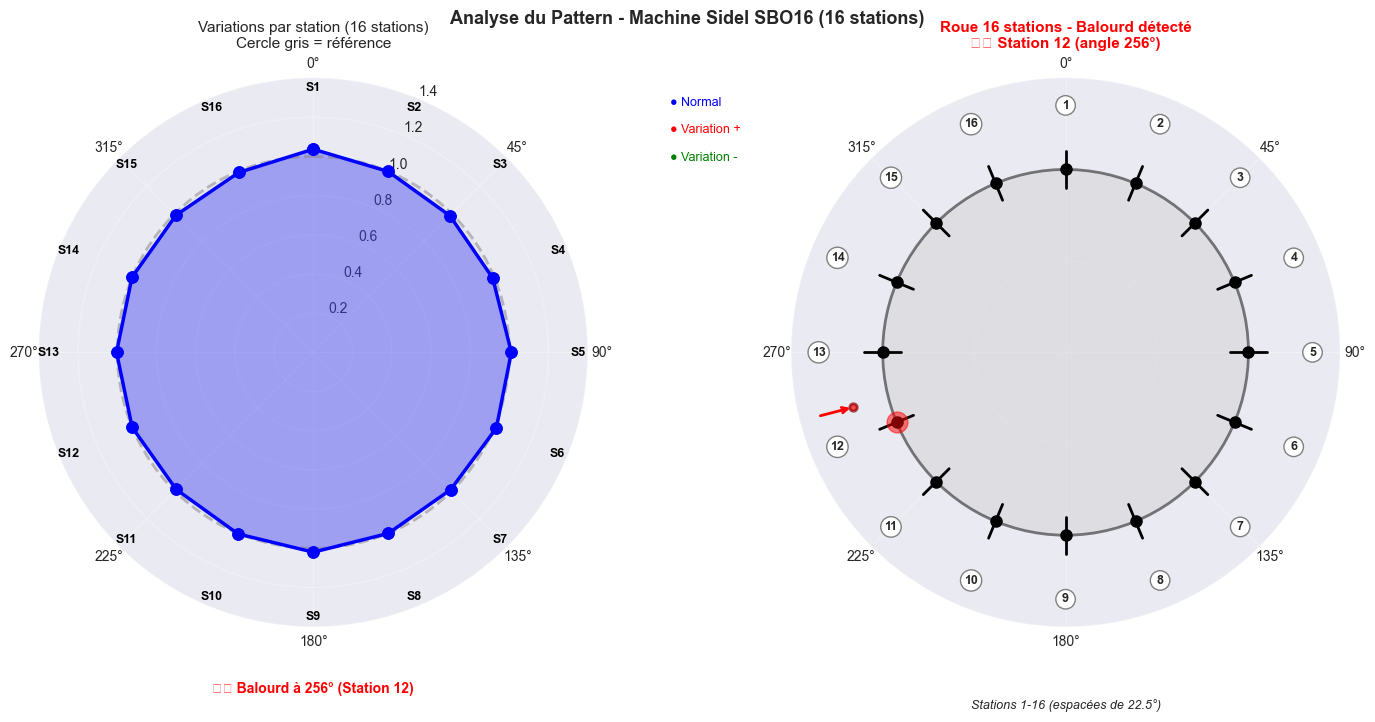


üìä INTERPR√âTATION DU GRAPHIQUE RADAR:
  ‚Ä¢ Machine configur√©e: SBO16 avec 16 stations
  ‚Ä¢ Espacement angulaire: 22.5¬∞ entre chaque station
  ‚Ä¢ Graphique gauche: Une valeur par station (polygone bleu)
  ‚Ä¢ Cercle gris = r√©f√©rence (pas de variation)
  ‚Ä¢ Plus le polygone s'√©loigne du cercle = plus forte variation

  ‚ö†Ô∏è BALOURD D√âTECT√â:
     ‚Ä¢ Position angulaire: 256¬∞
     ‚Ä¢ Station concern√©e: Station 12
     ‚Ä¢ ACTION: V√©rifier la Station 12 et son oppos√©e (Station 4)
     ‚Ä¢ √âquilibrage: Ajouter une masse √† la Station 4


In [357]:
def analyser_pattern_rotation(df):
    """
    Analyse le pattern de variation sur une rotation compl√®te
    """
    # Normaliser la position sur [0, 360] degr√©s
    position_norm = df['position_corrigee'].values
    position_deg = ((position_norm - position_norm[0]) % POINTS_PAR_TOUR) / POINTS_PAR_TOUR * 360
    
    # Cr√©er des bins pour moyenner par angle
    n_bins = 360  # 1 bin par degr√©
    bins = np.linspace(0, 360, n_bins + 1)
    
    # Moyenner les variations par angle
    variation_par_angle = []
    angles = []
    
    for i in range(n_bins):
        mask = (position_deg >= bins[i]) & (position_deg < bins[i+1])
        if np.sum(mask) > 0:
            variation_par_angle.append(df['variation_vitesse'].values[mask].mean())
            angles.append((bins[i] + bins[i+1]) / 2)
    
    variation_par_angle = np.array(variation_par_angle)
    angles = np.array(angles)
    
    # Calcul de l'amplitude de variation
    if len(variation_par_angle) > 0:
        amplitude_pattern = np.max(variation_par_angle) - np.min(variation_par_angle)
        angle_max = angles[np.argmax(variation_par_angle)]
        angle_min = angles[np.argmin(variation_par_angle)]
        
        print(f"\n‚úì Analyse du pattern de rotation")
        print(f"  Amplitude du pattern: {amplitude_pattern*100:.3f}%")
        print(f"  Angle de variation max: {angle_max:.1f}¬∞")
        print(f"  Angle de variation min: {angle_min:.1f}¬∞")
        
        # Crit√®re de balourd bas√© sur le pattern
        balourd_pattern = amplitude_pattern > SEUIL_VARIATION_VITESSE
        
        # Visualisation du pattern avec graphique radar
        visualiser_pattern_radar(angles, variation_par_angle, angle_max, angle_min, balourd_pattern)
        
        return angles, variation_par_angle, balourd_pattern, angle_max
    else:
        print("\n‚ö†Ô∏è Pas assez de donn√©es pour analyser le pattern de rotation")
        return None, None, False, None

def visualiser_pattern_radar(angles, variation_par_angle, angle_max, angle_min, balourd_detecte):
    """
    Cr√©e une visualisation radar (polaire) du pattern de rotation
    avec les stations de soufflage comme rep√®res
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), 
                                   subplot_kw=dict(projection='polar', theta_direction=-1, theta_offset=np.pi/2))
    
    # Calcul des positions angulaires des stations
    angles_stations = np.linspace(0, 360, NOMBRE_STATIONS + 1)[:-1]  # Exclure 360¬∞ (=0¬∞)
    theta_stations = np.deg2rad(angles_stations)
    
    # === GRAPHIQUE 1: Pattern de variation simplifi√© ===
    
    # Interpolation pour avoir une valeur par station
    variations_stations = []
    for angle_st in angles_stations:
        # Trouver la variation moyenne autour de cette station (¬±5¬∞)
        mask = np.abs(angles - angle_st) <= (180 / NOMBRE_STATIONS)
        if np.any(mask):
            variations_stations.append(np.mean(variation_par_angle[mask]))
        else:
            # Interpolation si pas de donn√©es
            idx = np.argmin(np.abs(angles - angle_st))
            variations_stations.append(variation_par_angle[idx])
    
    variations_stations = np.array(variations_stations)
    
    # Fermer le polygone pour le graphique
    theta_plot = np.append(theta_stations, theta_stations[0])
    variations_plot = np.append(variations_stations, variations_stations[0])
    
    # Normalisation : convertir les variations en rayon (1 = r√©f√©rence, >1 = variation positive)
    r_stations = 1 + variations_plot * 20  # Amplification pour visibilit√©
    
    # Tracer le cercle de r√©f√©rence (pas de variation)
    circle_theta = np.linspace(0, 2*np.pi, 100)
    ax1.plot(circle_theta, np.ones_like(circle_theta), 'gray', linestyle='--', linewidth=2, alpha=0.5)
    ax1.fill(circle_theta, np.ones_like(circle_theta), 'lightgray', alpha=0.2)
    
    # Tracer le pattern station par station
    ax1.plot(theta_plot, r_stations, 'b-', linewidth=2.5, marker='o', markersize=8)
    ax1.fill(theta_plot, r_stations, 'blue', alpha=0.3)
    
    # Marquer chaque station
    for i, (theta_st, var_st) in enumerate(zip(theta_stations, variations_stations)):
        r_st = 1 + var_st * 20
        # Colorer diff√©remment les stations avec forte variation
        if abs(var_st) > SEUIL_VARIATION_VITESSE:
            color = 'red' if var_st > 0 else 'green'
            size = 12
        else:
            color = 'blue'
            size = 8
        
        ax1.plot(theta_st, r_st, 'o', color=color, markersize=size)
        
        # Num√©ro de station √† l'ext√©rieur
        ax1.text(theta_st, 1.35, f'S{i+1}', ha='center', va='center', fontsize=9, 
                fontweight='bold', color='black')
    
    # Identifier la station la plus affect√©e bas√©e sur les variations par station
    if balourd_detecte:
        station_max_variation = np.argmax(abs(variations_stations)) + 1
        variation_max = variations_stations[station_max_variation - 1]
        
        # Trouver la station la plus proche de l'angle du balourd d√©tect√©
        station_balourd = np.argmin(np.abs(angles_stations - angle_max)) + 1
        
        # Utiliser la station bas√©e sur l'angle du balourd pour la coh√©rence
        ax1.text(0.5, -0.12, f'‚ö†Ô∏è Balourd √† {angle_max:.0f}¬∞ (Station {station_balourd})', 
                transform=ax1.transAxes, ha='center', fontsize=10, color='red', fontweight='bold')
    
    # Configuration du graphique
    ax1.set_ylim(0, 1.4)
    ax1.set_title(f'Variations par station ({NOMBRE_STATIONS} stations)\nCercle gris = r√©f√©rence', 
                 fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Ajout d'une l√©gende
    ax1.text(1.15, 0.95, '‚óè Normal', transform=ax1.transAxes, color='blue', fontsize=9)
    ax1.text(1.15, 0.90, '‚óè Variation +', transform=ax1.transAxes, color='red', fontsize=9)
    ax1.text(1.15, 0.85, '‚óè Variation -', transform=ax1.transAxes, color='green', fontsize=9)
    
    # === GRAPHIQUE 2: Repr√©sentation de la roue avec stations ===
    ax2.set_ylim(0, 1.5)
    
    # Dessiner la roue
    ax2.fill(circle_theta, np.ones_like(circle_theta), 'lightgray', alpha=0.5, edgecolor='black', linewidth=2)
    
    # Marquer les stations de soufflage
    for i, (angle_st, theta_st) in enumerate(zip(angles_stations, theta_stations)):
        # Ligne radiale pour chaque station
        ax2.plot([theta_st, theta_st], [0.9, 1.1], 'black', linewidth=2)
        # Point pour chaque station
        ax2.plot(theta_st, 1.0, 'ko', markersize=8)
        # Num√©ro de station √† l'ext√©rieur
        ax2.text(theta_st, 1.35, f'{i+1}', ha='center', va='center', fontsize=9, 
                fontweight='bold', bbox=dict(boxstyle='circle', facecolor='white', edgecolor='gray'))
    
    # Si balourd d√©tect√©, ajouter une masse
    if balourd_detecte:
        # Position du balourd
        balourd_theta = np.deg2rad(angle_max)
        
        # Dessiner le balourd comme une masse suppl√©mentaire
        balourd_size = abs(variation_par_angle[np.argmin(np.abs(angles - angle_max))]) * 5000
        ax2.scatter([balourd_theta], [1.2], s=balourd_size, c='red', alpha=0.7, 
                   edgecolors='darkred', linewidth=2)
        
        # Fl√®che indiquant le balourd
        ax2.annotate('', xy=(balourd_theta, 1.2), xytext=(balourd_theta, 1.4),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2))
        
        # Station affect√©e
        station_balourd = np.argmin(np.abs(angles_stations - angle_max)) + 1
        angle_station = angles_stations[station_balourd - 1]
        
        titre = f'Roue {NOMBRE_STATIONS} stations - Balourd d√©tect√©\n‚ö†Ô∏è Station {station_balourd} (angle {angle_max:.0f}¬∞)'
        couleur_titre = 'red'
        
        # Mettre en √©vidence la station affect√©e
        theta_station_balourd = np.deg2rad(angle_station)
        ax2.plot(theta_station_balourd, 1.0, 'ro', markersize=15, alpha=0.5)
    else:
        # Roue √©quilibr√©e
        ax2.text(0, 0, '‚úì', ha='center', va='center', fontsize=40, color='green', fontweight='bold')
        titre = f'Roue {NOMBRE_STATIONS} stations\n‚úì √âquilibrage correct'
        couleur_titre = 'green'
    
    # Configuration
    ax2.set_title(titre, fontsize=11, color=couleur_titre, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_rticks([0.5, 1, 1.5])
    ax2.set_yticklabels(['', '', ''])
    
    # L√©gende des stations
    ax2.text(0.5, -0.15, f'Stations 1-{NOMBRE_STATIONS} (espac√©es de {360/NOMBRE_STATIONS:.1f}¬∞)', 
            transform=ax2.transAxes, ha='center', fontsize=9, style='italic')
    
    plt.suptitle(f'Analyse du Pattern - Machine Sidel SBO{NOMBRE_STATIONS} ({NOMBRE_STATIONS} stations)', 
                fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Interpr√©tation textuelle adapt√©e aux stations
    print("\nüìä INTERPR√âTATION DU GRAPHIQUE RADAR:")
    print(f"  ‚Ä¢ Machine configur√©e: SBO{NOMBRE_STATIONS} avec {NOMBRE_STATIONS} stations")
    print(f"  ‚Ä¢ Espacement angulaire: {360/NOMBRE_STATIONS:.1f}¬∞ entre chaque station")
    print("  ‚Ä¢ Graphique gauche: Une valeur par station (polygone bleu)")
    print("  ‚Ä¢ Cercle gris = r√©f√©rence (pas de variation)")
    print("  ‚Ä¢ Plus le polygone s'√©loigne du cercle = plus forte variation")
    
    if balourd_detecte:
        # Utiliser la station bas√©e sur l'angle du balourd pour la coh√©rence
        station_balourd = np.argmin(np.abs(angles_stations - angle_max)) + 1
        station_opposee = ((station_balourd - 1 + NOMBRE_STATIONS//2) % NOMBRE_STATIONS) + 1
        print(f"\n  ‚ö†Ô∏è BALOURD D√âTECT√â:")
        print(f"     ‚Ä¢ Position angulaire: {angle_max:.0f}¬∞")
        print(f"     ‚Ä¢ Station concern√©e: Station {station_balourd}")
        print(f"     ‚Ä¢ ACTION: V√©rifier la Station {station_balourd} et son oppos√©e (Station {station_opposee})")
        print(f"     ‚Ä¢ √âquilibrage: Ajouter une masse √† la Station {station_opposee}")

angles, variation_par_angle, balourd_pattern, angle_balourd = analyser_pattern_rotation(df)

## 8. Diagnostic final du balourd

In [358]:
def diagnostiquer_balourd(df, balourd_fft, balourd_pattern, amplitude_fft_max=None):
    """
    Effectue le diagnostic final de pr√©sence de balourd
    """
    diagnostic = {
        'balourd_detecte': False,
        'confiance': 0,
        'severite': 'Aucune',
        'angle_balourd': angle_balourd if angle_balourd else None,
        'recommandations': []
    }
    
    # Calcul des m√©triques
    variation_max = df['variation_vitesse'].abs().max()
    variation_std = df['variation_vitesse'].std()
    
    # Crit√®res de d√©tection
    criteres = {
        'variation_vitesse': variation_max > SEUIL_VARIATION_VITESSE,
        'ecart_type_eleve': variation_std > SEUIL_VARIATION_VITESSE / 2,
        'signature_fft': balourd_fft,
        'pattern_rotation': balourd_pattern
    }
    
    # Calcul du score de confiance
    nb_criteres_valides = sum(criteres.values())
    diagnostic['confiance'] = nb_criteres_valides / len(criteres)
    
    # D√©termination du balourd
    if nb_criteres_valides >= 2:  # Au moins 2 crit√®res sur 4
        diagnostic['balourd_detecte'] = True
        
        # √âvaluation de la s√©v√©rit√© bas√©e sur l'amplitude de variation
        if variation_max > 0.02:  # 2%
            diagnostic['severite'] = 'CRITIQUE'
            diagnostic['recommandations'].append("‚ö†Ô∏è URGENT: Arr√™t et √©quilibrage imm√©diat recommand√©")
            diagnostic['recommandations'].append("üìç Risque de dommages m√©caniques")
        elif variation_max > 0.01:  # 1%
            diagnostic['severite'] = '√âlev√©e'
            diagnostic['recommandations'].append("‚ö†Ô∏è Planifier un √©quilibrage rapidement")
            diagnostic['recommandations'].append("üìä Surveiller l'√©volution quotidiennement")
        elif variation_max > 0.005:  # 0.5%
            diagnostic['severite'] = 'Mod√©r√©e'
            diagnostic['recommandations'].append("‚ÑπÔ∏è Balourd d√©tect√© mais acceptable temporairement")
            diagnostic['recommandations'].append("üìÖ Pr√©voir un √©quilibrage lors de la prochaine maintenance")
        else:
            diagnostic['severite'] = 'Faible'
            diagnostic['recommandations'].append("‚ÑπÔ∏è Balourd l√©ger d√©tect√©")
            diagnostic['recommandations'].append("üëÅÔ∏è Surveiller l'√©volution mensuellement")
        
        if diagnostic['angle_balourd'] is not None:
            diagnostic['recommandations'].append(f"üéØ Position du balourd: {diagnostic['angle_balourd']:.0f}¬∞")
    else:
        diagnostic['recommandations'].append("‚úÖ Aucun balourd significatif d√©tect√©")
        diagnostic['recommandations'].append("‚ÑπÔ∏è Continuer la surveillance p√©riodique")
        diagnostic['recommandations'].append("üìà Les variations observ√©es sont dans les limites normales")
    
    # Affichage du diagnostic
    print("\n" + "="*60)
    print("DIAGNOSTIC FINAL")
    print("="*60)
    print(f"üîç Balourd d√©tect√©: {'OUI' if diagnostic['balourd_detecte'] else 'NON'}")
    print(f"üìä Niveau de confiance: {diagnostic['confiance']:.0%}")
    print(f"‚ö° S√©v√©rit√©: {diagnostic['severite']}")
    print(f"\nüìà M√©triques cl√©s:")
    print(f"  ‚Ä¢ Variation maximale: {variation_max*100:.3f}%")
    print(f"  ‚Ä¢ √âcart-type: {variation_std*100:.3f}%")
    print(f"\nüìã D√©tail des crit√®res:")
    for critere, valide in criteres.items():
        print(f"  {'‚úì' if valide else '‚úó'} {critere}: {'Valid√©' if valide else 'Non valid√©'}")
    print(f"\nüí° Recommandations:")
    for recommandation in diagnostic['recommandations']:
        print(f"  {recommandation}")
    
    return diagnostic

diagnostic = diagnostiquer_balourd(df, balourd_fft, balourd_pattern if angles is not None else False)


DIAGNOSTIC FINAL
üîç Balourd d√©tect√©: OUI
üìä Niveau de confiance: 50%
‚ö° S√©v√©rit√©: √âlev√©e

üìà M√©triques cl√©s:
  ‚Ä¢ Variation maximale: 1.319%
  ‚Ä¢ √âcart-type: 0.242%

üìã D√©tail des crit√®res:
  ‚úì variation_vitesse: Valid√©
  ‚úó ecart_type_eleve: Non valid√©
  ‚úó signature_fft: Non valid√©
  ‚úì pattern_rotation: Valid√©

üí° Recommandations:
  ‚ö†Ô∏è Planifier un √©quilibrage rapidement
  üìä Surveiller l'√©volution quotidiennement
  üéØ Position du balourd: 256¬∞


## 9. Visualisation compl√®te des r√©sultats

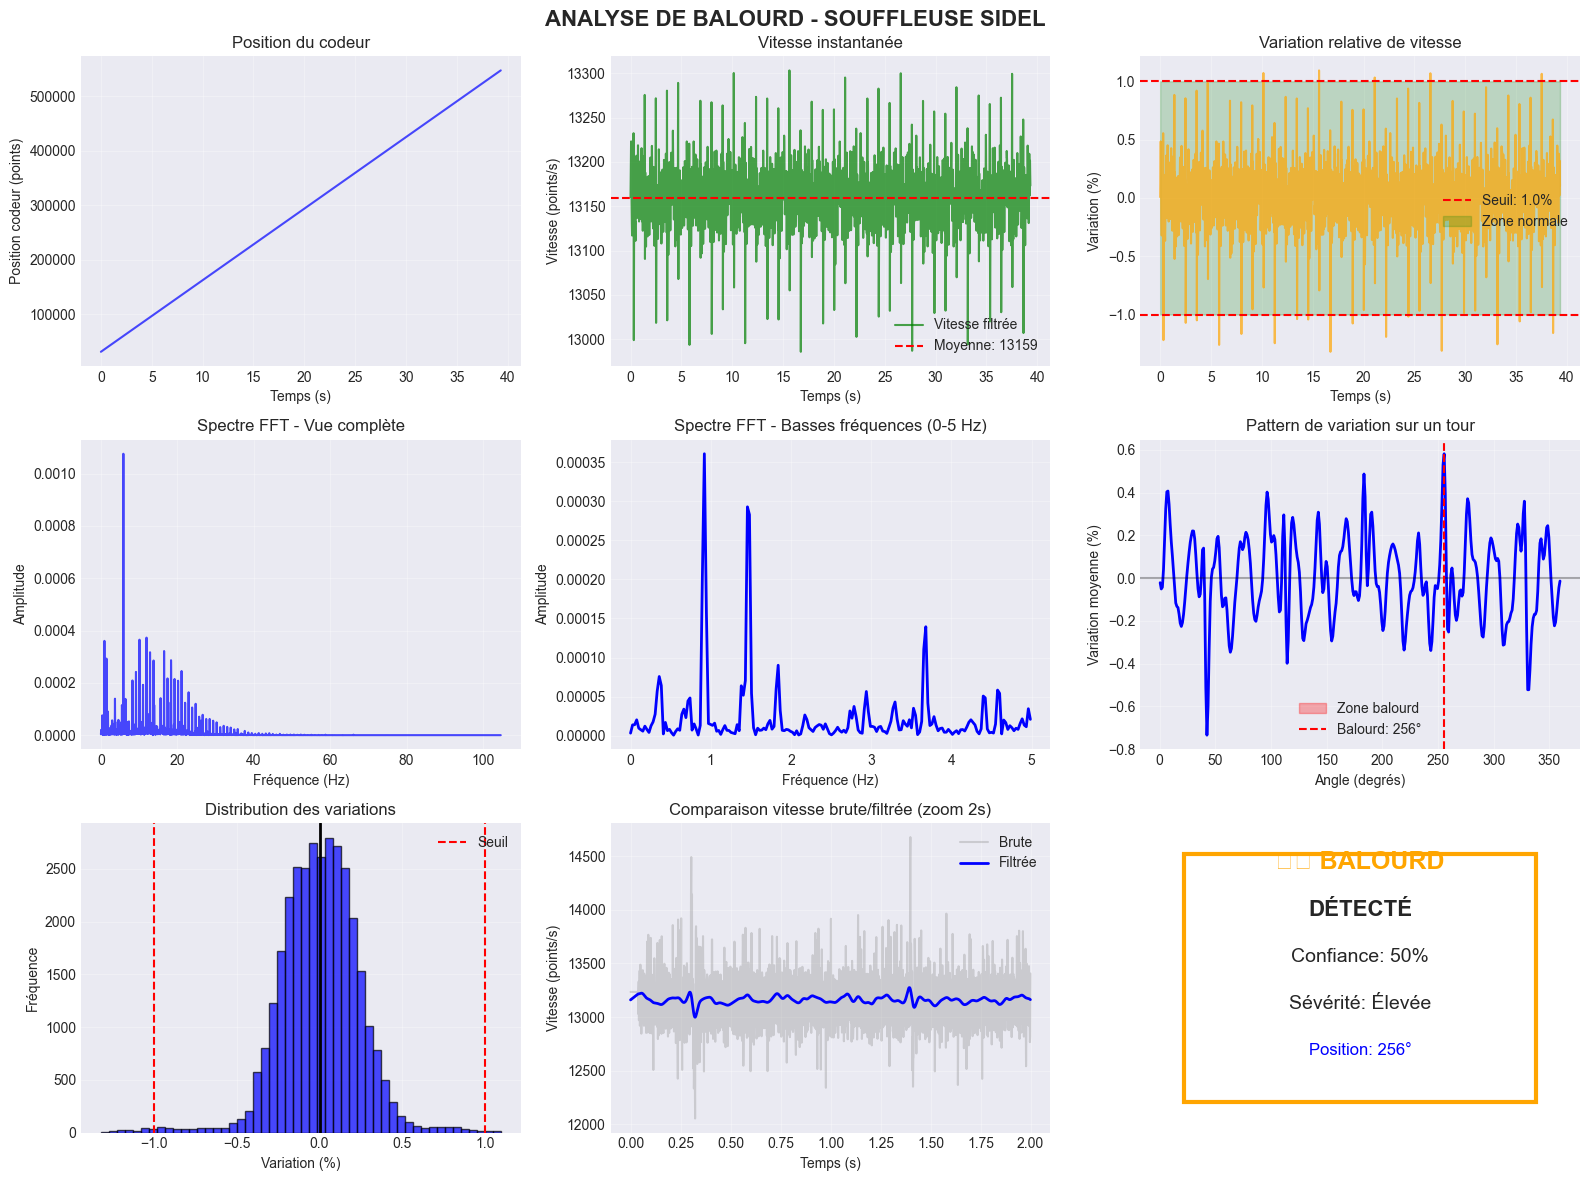

In [359]:
def visualiser_resultats_complets(df, frequencies, amplitudes, peaks, 
                                  angles, variation_par_angle, diagnostic):
    """
    Cr√©e une visualisation compl√®te des r√©sultats d'analyse
    """
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Position du codeur dans le temps
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(df['temps'], df['position_corrigee'], 'b-', alpha=0.7)
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Position codeur (points)')
    ax1.set_title('Position du codeur')
    ax1.grid(True, alpha=0.3)
    
    # 2. Vitesse instantan√©e
    ax2 = plt.subplot(3, 3, 2)
    ax2.plot(df['temps'], df['vitesse_filtree'], 'g-', alpha=0.7, label='Vitesse filtr√©e')
    ax2.axhline(y=df['vitesse_filtree'].mean(), color='r', linestyle='--', 
                label=f'Moyenne: {df["vitesse_filtree"].mean():.0f}')
    ax2.set_xlabel('Temps (s)')
    ax2.set_ylabel('Vitesse (points/s)')
    ax2.set_title('Vitesse instantan√©e')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Variation de vitesse (%)
    ax3 = plt.subplot(3, 3, 3)
    ax3.plot(df['temps'], df['variation_vitesse']*100, 'orange', alpha=0.7)
    ax3.axhline(y=SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--', 
                label=f'Seuil: {SEUIL_VARIATION_VITESSE*100:.1f}%')
    ax3.axhline(y=-SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--')
    ax3.fill_between(df['temps'], -SEUIL_VARIATION_VITESSE*100, SEUIL_VARIATION_VITESSE*100, 
                     alpha=0.2, color='green', label='Zone normale')
    ax3.set_xlabel('Temps (s)')
    ax3.set_ylabel('Variation (%)')
    ax3.set_title('Variation relative de vitesse')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Spectre FFT complet
    ax4 = plt.subplot(3, 3, 4)
    ax4.plot(frequencies[:len(frequencies)//4], amplitudes[:len(frequencies)//4], 'b-', alpha=0.7)
    if len(peaks) > 0:
        ax4.plot(frequencies[peaks], amplitudes[peaks], 'ro', markersize=8, label='Pics d√©tect√©s')
    ax4.set_xlabel('Fr√©quence (Hz)')
    ax4.set_ylabel('Amplitude')
    ax4.set_title('Spectre FFT - Vue compl√®te')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Spectre FFT zoom basses fr√©quences
    ax5 = plt.subplot(3, 3, 5)
    mask_bf = frequencies < 5  # Zoom sur 0-5 Hz
    ax5.plot(frequencies[mask_bf], amplitudes[mask_bf], 'b-', linewidth=2)
    peaks_bf = peaks[peaks < np.sum(mask_bf)]
    if len(peaks_bf) > 0:
        ax5.plot(frequencies[peaks_bf], amplitudes[peaks_bf], 'ro', markersize=10)
        for peak in peaks_bf[:3]:  # Annoter les 3 premiers pics
            ax5.annotate(f'{frequencies[peak]:.2f} Hz', 
                        xy=(frequencies[peak], amplitudes[peak]),
                        xytext=(10, 10), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))
    ax5.set_xlabel('Fr√©quence (Hz)')
    ax5.set_ylabel('Amplitude')
    ax5.set_title('Spectre FFT - Basses fr√©quences (0-5 Hz)')
    ax5.grid(True, alpha=0.3)
    
    # 6. Pattern de variation par angle
    ax6 = plt.subplot(3, 3, 6)
    if angles is not None and variation_par_angle is not None:
        ax6.plot(angles, variation_par_angle*100, 'b-', linewidth=2)
        ax6.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax6.fill_between(angles, 0, variation_par_angle*100, 
                         where=(variation_par_angle*100 > SEUIL_VARIATION_VITESSE*100), 
                         color='red', alpha=0.3, label='Zone balourd')
        if diagnostic['angle_balourd']:
            ax6.axvline(x=diagnostic['angle_balourd'], color='red', linestyle='--', 
                       label=f'Balourd: {diagnostic["angle_balourd"]:.0f}¬∞')
        ax6.set_xlabel('Angle (degr√©s)')
        ax6.set_ylabel('Variation moyenne (%)')
        ax6.set_title('Pattern de variation sur un tour')
        ax6.legend()
    else:
        ax6.text(0.5, 0.5, 'Donn√©es insuffisantes\npour le pattern', 
                ha='center', va='center', fontsize=12)
    ax6.grid(True, alpha=0.3)
    
    # 7. Histogramme des variations
    ax7 = plt.subplot(3, 3, 7)
    ax7.hist(df['variation_vitesse']*100, bins=50, color='blue', alpha=0.7, edgecolor='black')
    ax7.axvline(x=0, color='k', linestyle='-', linewidth=2)
    ax7.axvline(x=SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--', label='Seuil')
    ax7.axvline(x=-SEUIL_VARIATION_VITESSE*100, color='r', linestyle='--')
    ax7.set_xlabel('Variation (%)')
    ax7.set_ylabel('Fr√©quence')
    ax7.set_title('Distribution des variations')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Vitesse brute vs filtr√©e (zoom)
    ax8 = plt.subplot(3, 3, 8)
    # Zoom sur les 2 premi√®res secondes
    mask_zoom = df['temps'] < 2
    ax8.plot(df['temps'][mask_zoom], df['vitesse_brute'][mask_zoom], 
            'gray', alpha=0.3, label='Brute')
    ax8.plot(df['temps'][mask_zoom], df['vitesse_filtree'][mask_zoom], 
            'b-', linewidth=2, label='Filtr√©e')
    ax8.set_xlabel('Temps (s)')
    ax8.set_ylabel('Vitesse (points/s)')
    ax8.set_title('Comparaison vitesse brute/filtr√©e (zoom 2s)')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    # 9. Diagnostic visuel
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    
    # Cr√©ation d'un indicateur visuel
    if diagnostic['balourd_detecte']:
        if diagnostic['severite'] == 'CRITIQUE':
            couleur = 'red'
            symbole = '‚ö†Ô∏è'
        elif diagnostic['severite'] == '√âlev√©e':
            couleur = 'orange'
            symbole = '‚ö†Ô∏è'
        else:
            couleur = 'yellow'
            symbole = '‚ö°'
    else:
        couleur = 'green'
        symbole = '‚úì'
    
    # Affichage du diagnostic
    ax9.text(0.5, 0.85, f"{symbole} BALOURD", 
             fontsize=18, fontweight='bold', color=couleur, ha='center')
    ax9.text(0.5, 0.70, f"{'D√âTECT√â' if diagnostic['balourd_detecte'] else 'NON D√âTECT√â'}", 
             fontsize=16, fontweight='bold', ha='center')
    ax9.text(0.5, 0.55, f"Confiance: {diagnostic['confiance']:.0%}", 
             fontsize=14, ha='center')
    ax9.text(0.5, 0.40, f"S√©v√©rit√©: {diagnostic['severite']}", 
             fontsize=14, ha='center')
    
    if diagnostic['angle_balourd'] is not None:
        ax9.text(0.5, 0.25, f"Position: {diagnostic['angle_balourd']:.0f}¬∞", 
                fontsize=12, ha='center', color='blue')
    
    # Cadre autour du diagnostic
    rect = plt.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=3, 
                         edgecolor=couleur, facecolor='none')
    ax9.add_patch(rect)
    
    plt.suptitle('ANALYSE DE BALOURD - SOUFFLEUSE SIDEL', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Affichage de la visualisation
visualiser_resultats_complets(df, frequencies, amplitudes, peaks, 
                             angles, variation_par_angle, diagnostic)

## 10. Export des r√©sultats d√©taill√©s

In [360]:
def exporter_resultats_detailles(df, diagnostic, frequencies, amplitudes, peaks, 
                                 angles, variation_par_angle, 
                                 nom_fichier='resultats_balourd_sidel.xlsx'):
    """
    Exporte les r√©sultats d√©taill√©s de l'analyse dans un fichier Excel
    """
    try:
        with pd.ExcelWriter(nom_fichier, engine='openpyxl') as writer:
            # Feuille 1: Donn√©es principales
            df_export = df[['temps', 'position_codeur', 'position_corrigee', 
                          'vitesse_filtree', 'variation_vitesse']].copy()
            df_export['variation_pourcent'] = df_export['variation_vitesse'] * 100
            df_export.to_excel(writer, sheet_name='Donn√©es', index=False, float_format='%.6f')
            
            # Feuille 2: Diagnostic
            df_diagnostic = pd.DataFrame({
                'Param√®tre': [
                    'Balourd d√©tect√©',
                    'Niveau de confiance',
                    'S√©v√©rit√©',
                    'Variation maximale (%)',
                    '√âcart-type variation (%)',
                    'Angle du balourd (¬∞)',
                    'Vitesse moyenne (points/s)',
                    'Nombre de points analys√©s',
                    'Dur√©e totale (s)',
                    'Tours effectu√©s'
                ],
                'Valeur': [
                    'OUI' if diagnostic['balourd_detecte'] else 'NON',
                    f"{diagnostic['confiance']:.0%}",
                    diagnostic['severite'],
                    f"{df['variation_vitesse'].abs().max()*100:.3f}",
                    f"{df['variation_vitesse'].std()*100:.3f}",
                    f"{diagnostic['angle_balourd']:.1f}" if diagnostic['angle_balourd'] else 'N/A',
                    f"{df['vitesse_filtree'].mean():.1f}",
                    len(df),
                    f"{df['temps'].iloc[-1] - df['temps'].iloc[0]:.3f}",
                    f"{(df['position_corrigee'].iloc[-1] - df['position_corrigee'].iloc[0]) / POINTS_PAR_TOUR:.2f}"
                ]
            })
            df_diagnostic.to_excel(writer, sheet_name='Diagnostic', index=False)
            
            # Feuille 3: Analyse FFT
            if len(peaks) > 0:
                df_fft = pd.DataFrame({
                    'Fr√©quence (Hz)': frequencies[peaks],
                    'Amplitude': amplitudes[peaks]
                })
                df_fft = df_fft.sort_values('Amplitude', ascending=False)
                df_fft.to_excel(writer, sheet_name='Pics_FFT', index=False, float_format='%.6f')
            
            # Feuille 4: Pattern angulaire
            if angles is not None and variation_par_angle is not None:
                df_pattern = pd.DataFrame({
                    'Angle (deg)': angles,
                    'Variation moyenne (%)': variation_par_angle * 100
                })
                df_pattern.to_excel(writer, sheet_name='Pattern_angulaire', index=False, float_format='%.3f')
            
            # Feuille 5: Recommandations
            df_recommandations = pd.DataFrame({
                'Recommandations': diagnostic['recommandations']
            })
            df_recommandations.to_excel(writer, sheet_name='Recommandations', index=False)
        
        print(f"\n‚úÖ R√©sultats export√©s dans '{nom_fichier}'")
        return True
    
    except Exception as e:
        print(f"\n‚ùå Erreur lors de l'export: {e}")
        return False

# Export des r√©sultats
exporter_resultats_detailles(df, diagnostic, frequencies, amplitudes, peaks, 
                            angles, variation_par_angle)


‚ùå Erreur lors de l'export: No module named 'openpyxl'


False